# Adversarial Attacks

The following code is loading the Tesseract dataset towards doing an adversarial attack.

In [2]:
import os
import json
import datetime
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import DictVectorizer
from tesseract import evaluation, temporal 
from sklearn.model_selection import train_test_split

os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

## Loading features
def load_dataset(dataset_path):
    """
    The function to load features in the Tesseract dataset. Please note that you have to parametrize the names of the files opened, to load the right file. 
    """
    print(f'Loading dataset from {dataset_path}')

    with open('{}-X-updated-reduced-10k.json'.format(dataset_path), 'r') as f:
        X = json.load(f)

    print('Loading labels...')
    with open('{}-y-updated.json'.format(dataset_path), 'rt') as f:
        y = json.load(f)

    print('Loading timestamps...')
    with open('{}-meta-updated.json'.format(dataset_path), 'rt') as f:
        T = json.load(f)
    T = [o['dex_date'] for o in T]
    T = np.array([datetime.datetime.strptime(o, '%Y-%m-%dT%H:%M:%S') if "T" in o
             else datetime.datetime.strptime(o, '%Y-%m-%d %H:%M:%S') for o in T])

    # Convert to numpy array and get feature names
    vec =  DictVectorizer()
    X = vec.fit_transform(X).astype("float32")
    y = np.asarray(y)
    feature_names = vec.get_feature_names_out()

    # Get time index of each sample for easy reference
    time_index = {}
    for i in range(len(T)):
        t = T[i]
        if t.year not in time_index:
            time_index[t.year] = {}
        if t.month not in time_index[t.year]:
            time_index[t.year][t.month] = []
        time_index[t.year][t.month].append(i)

    return X, y, time_index, feature_names, T

X, y, time_index, feature_names, T = load_dataset('/Users/fabio/work/mlsec-malware-class/labs/extended-features/extended-features')

# Following DREBIN feature-space
clf = LinearSVC(C=1)

# Random split of train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Training the classifier
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Loading dataset from /Users/fabio/work/mlsec-malware-class/labs/extended-features/extended-features
Loading labels...
Loading timestamps...


/usr/local/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Exercise 1: Evasion of a single point (Linear Classifier)

Generate an adversarial attack for a single point. Get the most important benign feature of the svm (hint: look at `coef_[0]`), and swap it to a 1.0 (the feature space is binary).

Notes: you should attack only true positives!

In [3]:
# Attacking a single point


# mask for identifying true positives
tp_mask = (y_pred==1.0) & (y_test==1.0)
X_tps = X_test[tp_mask,:]

test_point = X_tps[0].toarray()
print('Before attack: {}'.format(clf.predict(test_point)))
top_10_benign_idx = np.argsort(clf.coef_[0])[:10]
test_point[:, top_10_benign_idx] = 1.0
print('After attack: {}'.format(clf.predict(test_point)))

Before attack: [1.]
After attack: [0.]


## Exercise 2: Security Evaluation Curves (Linear Classifier)

Create a function that modifies the top-1, top-2, ... top-N features to all samples, and draws a security evaluation curve as follows: the number of modified features on the X-axis, and the attack success rate on the Y-axis.

Note: you should attack only true positives!

In [8]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


asr = []
for top_n in tqdm(range(11)):
    y_before = []
    y_after = []
    X_tps = X_test[tp_mask,:]
    print('Attacking {} tps with {} top benign...'.format(np.sum(tp_mask), top_n))
    top_10_benign_idx = np.argsort(clf.coef_[0])[:top_n]
    for test_point in X_tps:
        y_before.append(clf.predict(test_point)[0])
        test_point[:, top_10_benign_idx] = 1.0
        y_after.append(clf.predict(test_point)[0])
    y_before = np.array(y_before)
    y_after = np.array(y_after)
    asr.append(np.sum((y_before==1.0) & (y_after==0.0))/len(y_before))

  0%|          | 0/11 [00:00<?, ?it/s]

Attacking 7325 tps with 0 top benign...
Attacking 7325 tps with 1 top benign...


/usr/local/lib/python3.11/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Attacking 7325 tps with 2 top benign...
Attacking 7325 tps with 3 top benign...
Attacking 7325 tps with 4 top benign...
Attacking 7325 tps with 5 top benign...
Attacking 7325 tps with 6 top benign...
Attacking 7325 tps with 7 top benign...
Attacking 7325 tps with 8 top benign...
Attacking 7325 tps with 9 top benign...
Attacking 7325 tps with 10 top benign...


ASR: [0.0, 0.6580204778156996, 0.9010238907849829, 0.9762457337883959, 0.9918088737201365, 0.9989078498293515, 0.9994539249146758, 0.9995904436860068, 0.999863481228669, 0.999863481228669, 1.0]


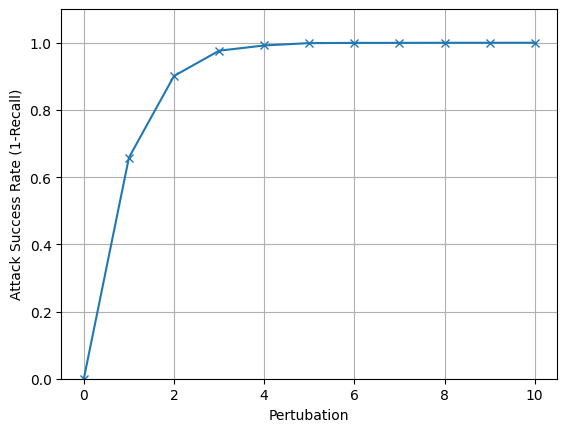

In [10]:
print('ASR: {}'.format(asr))
plt.xlabel('Pertubation')
plt.ylabel('Attack Success Rate (1-Recall)')
plt.plot(asr, marker='x')
plt.ylim([0,1.1])
plt.grid()